In [2]:
from pprint import pprint

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt


import prepare as pr 

In [130]:
df = pd.read_csv('all_books.csv')

In [131]:
pr.c

In [132]:
save.head(1)

,Unnamed: 0,title,summary,year_published,author,review_count,number_of_ratings,length,genre,rating,reviews,book_tag
0,196,Alice's Adventures in Wonderland: A Pop-Up Ada...,Alice's Adventures in Wonderland is Robert Sa...,2003,Robert Sabuda,157,26214,12.0,Classics,4.34,[],NaN


# Clean DataFrame for Modeling

In [136]:
df 

,Unnamed: 0,title,summary,year_published,author,review_count,number_of_ratings,length,genre,rating,reviews,book_tag
0,196,Alice's Adventures in Wonderland: A Pop-Up Ada...,Alice's Adventures in Wonderland is Robert Sa...,2003,Robert Sabuda,157,26214,12.0,Classics,4.34,[],NaN
1,205,Just Me in the Tub,Taking a bath is a big job. Mercer Mayer's fam...,1994,Gina Mayer,62,19212,24.0,Childrens,4.25,[],NaN
2,334,The Rats in the Walls,"""The Rats in the Walls"" is a short story by H....",1924,H.P. Lovecraft,531,9155,25.0,Horror,4.01,[],NaN
3,180,Sheep in a Jeep,A flock of hapless sheep drive through the cou...,1986,Nancy E. Shaw,701,17358,26.0,Picture Books,4.13,[],NaN
4,312,Baby Jaimie Gets Stage Fright,NaN,2011,Jaimie Hope,7,21,26.0,Childrens,4.00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3993,6,Evenfall,NOTE FROM THE AUTHORS:This is the OLD version ...,2007,Ais,562,5115,1427.0,M M Romance,4.19,[],NaN
3994,2201,The Fiery Cross,"The year is 1771, and war is coming. Jamie Fra...",2001,Diana Gabaldon,8425,199251,1443.0,Historical Fiction,4.25,NaN,NaN
3995,2970,War and Peace,Tolstoy's epic masterpiece intertwines the liv...,1869,Leo Tolstoy,15480,308202,1700.0,Classics,4.15,NaN,NaN
3996,2510,"The Norton Anthology of English Literature, Vo...",Firmly grounded by the hallmark strengths of a...,1962,M.H. Abrams,179,9045,2904.0,Classics,4.22,NaN,NaN


In [135]:
df.drop(columns= ['title','year_published','reviews','clean_title'])

KeyError: "['clean_title'] not found in axis"

In [87]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
df = pr.prep_data('all_books.csv') 

In [5]:
data = df.copy()

# NLP

# Count Vector

In [6]:
data.head(1)

,title,summary,year_published,author,review_count,number_of_ratings,length,genre,rating,reviews,cleaned_title,cleaned_summary,target,lemmatized_summary,neg,neutral,pos,compound,sentiment
0,1491,"In this groundbreaking work of science, histor...",back,Charles C. Mann,4581,81796,1492.0,History,4.04,NaN,1491,"in this groundbreaking work of science, histor...",unsuccessful,groundbreaking science history archaeology cha...,0.021,0.848,0.132,0.9393,very positive


In [7]:
#  document= 'mary had a '

In [25]:
document = data.lemmatized_summary.tolist()

In [14]:
document = data.lemmatized_summary

In [33]:
cv = CountVectorizer()
# use the thing
bag_of_words = cv.fit_transform(document)

In [34]:
bag_of_words.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [27]:
bow = pd.DataFrame(bag_of_words.todense())
bow.columns = cv.get_feature_names()

/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [28]:
bow

,aa,aahz,aambc,aanen,aarav,aardema,aaron,aaronovitch,aaronsohn,ab,...,zuckoff,zuckoffs,zula,zum,zumindest,zuni,zusak,zuversicht,zwanzig,zwischen
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3805,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3806,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3807,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3808,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
bow.apply(lambda row: row / row.sum(), axis=1)

,aa,aahz,aambc,aanen,aarav,aardema,aaron,aaronovitch,aaronsohn,ab,...,zuckoff,zuckoffs,zula,zum,zumindest,zuni,zusak,zuversicht,zwanzig,zwischen
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3805,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3806,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3807,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3808,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
# decision tree

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [36]:
X = df.lemmatized_summary
y = df.target

In [41]:
x_train, x_test, y_train, y_test = \
train_test_split(X, y, 
                 test_size=0.2, 
                 random_state=42)

# fit train

In [44]:
# Whatever transformations we apply to X_train need to be applied to X_test
cv = CountVectorizer()
x_bow = cv.fit_transform(x_train) 

In [47]:

from sklearn.metrics import recall_score


In [55]:
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(x_bow, y_train)

DecisionTreeClassifier(max_depth=3)

In [56]:
y_pred = tree.predict(x_bow)

In [59]:
# Calculate the recall score
recall = recall_score(y_train, y_pred, pos_label='best seller')
print("Recall score for 'best seller' class:", recall)
# print("Recall score on training data:", recall)

Recall score for 'best seller' class: 0.09022556390977443


In [61]:
# import confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import  ConfusionMatrixDisplay

In [64]:
ConfusionMatrixDisplay(
confusion_matrix = confusion_matrix(y_train, y_pred), 
display_labels = ['unsuccessful', 'best seller'])


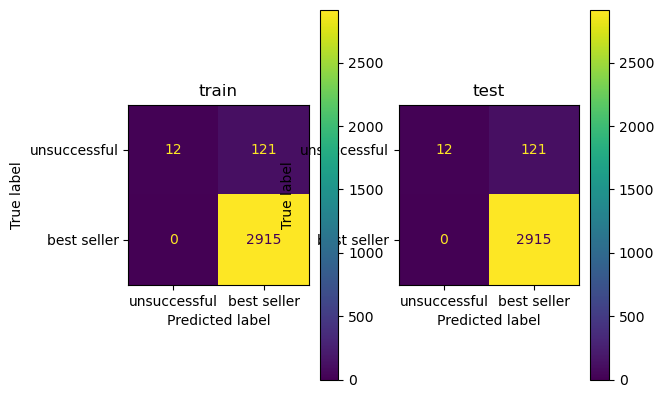

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# assume y_train and y_train_pred are your target variable and predicted labels, respectively
# and y_test and y_pred are your test set target variable and predicted labels, respectively
fig, ax = plt.subplots(1, 2)
ax[0].set_title("train")
ax[1].set_title("test")

# plot confusion matrix for training data
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, y_pred),
                       display_labels=['unsuccessful', 'best seller']).plot(ax=ax[0])

# plot confusion matrix for test data
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, y_pred),
                       display_labels=['unsuccessful', 'best seller']).plot(ax=ax[1])

plt.show()

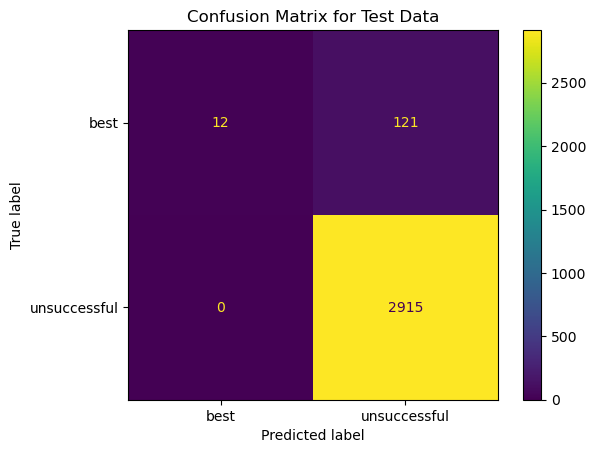

In [71]:
# assume y_test and y_pred are your test set target variable and predicted labels, respectively
cm = confusion_matrix(y_train, y_pred)

# plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['best', 'unsuccessful'])
disp.plot()
disp.ax_.set_title("Confusion Matrix for Test Data")

plt.show()

In [73]:
# create an instance with predetermined values 
clf_xgb = xgb.XGBClassifier(objective ='binary:logistic', 
                                        seed = 42,
                                        max_depth = 3,    
                                        scale_pos_weight= 5,
                                        learning_rate = .01,
                                        subsample = .9,
                                        colsample_bytree = .5,
                                        n_jobs = 10)

In [89]:
label_encoder = LabelEncoder()


In [91]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

vectorizer = CountVectorizer()
x_bow_train = vectorizer.fit_transform(x_train)
x_bow_test = vectorizer.transform(x_test)

In [92]:
# create an instance with predetermined values 
xgb = xgb.XGBClassifier(objective ='binary:logistic', 
                                        seed = 42,
                                        max_depth = 3,    
                                        scale_pos_weight= 5,
                                        learning_rate = .01,
                                        subsample = .9,
                                        colsample_bytree = .5,
                                        n_jobs = 10)



In [93]:
xgb.fit(x_bow_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=10, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [94]:
# make predictions on test set
y_pred = xgb.predict(x_bow_train)

# evaluate classifier performance
accuracy = xgb.score(x_bow_train, y_train)
print("Accuracy:", accuracy)

Accuracy: 0.9593175853018373


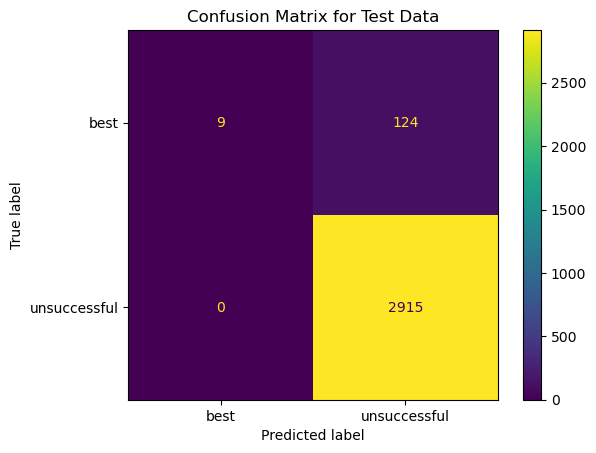

In [100]:
# assume y_test and y_pred are your test set target variable and predicted labels, respectively
cm = confusion_matrix(y_train, y_pred)

# plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['best', 'unsuccessful'])
disp.plot()
disp.ax_.set_title("Confusion Matrix for Test Data")

plt.show()

<3048x31768 sparse matrix of type '<class 'numpy.int64'>'
	with 243149 stored elements in Compressed Sparse Row format>

In [116]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score


In [123]:
def th_hyperparam_tuning(x_train, y_train, x_test, y_test, max_depths, scale_pos_weights, learning_rates, subsamples, colsample_bytrees):
    for max_depth in max_depths:
        for scale_pos_weight in scale_pos_weights:
            for learning_rate in learning_rates:
                for subsample in subsamples:
                    for colsample_bytree in colsample_bytrees:
                        # define the XGBClassifier with the current hyperparameters
                        xgb_model = XGBClassifier(objective ='binary:logistic', 
                                                  seed=42,
                                                  max_depth=max_depth,
                                                  scale_pos_weight=scale_pos_weight,
                                                  learning_rate=learning_rate,
                                                  subsample=subsample,
                                                  colsample_bytree=colsample_bytree,
                                                  n_jobs=10)
                        # fit the model on the training set
                        xgb_model.fit(x_train, y_train)
                        # predict on the test set
                        y_pred = xgb_model.predict(x_test)
                        # print the hyperparameters and the resulting f1-score
                        print(f"max_depth={max_depth}, scale_pos_weight={scale_pos_weight}, learning_rate={learning_rate}, subsample={subsample}, colsample_bytree={colsample_bytree}: f1-score={f1_score(y_test, y_pred)},: recall-score={recall_score(y_test, y_pred)}")
                        print('\n')
                        # print the confusion matrix
                        print(confusion_matrix(y_test, y_pred))
                        print('\n')
                        

SyntaxError: invalid syntax (753303334.py, line 2)

In [122]:
max_depths = [3, 5, 7]
scale_pos_weights = [3, 5, 7]
learning_rates = [0.01, 0.1, 1]
subsamples = [0.7, 0.8, 0.9]
colsample_bytrees = [0.5, 0.6, 0.7]

th_hyperparam_tuning(x_bow_train, y_train, x_bow_test, y_test, max_depths, scale_pos_weights, learning_rates, subsamples, colsample_bytrees)

max_depth=3, scale_pos_weight=3, learning_rate=0.01, subsample=0.7, colsample_bytree=0.5: f1-score=0.9812834224598931,: recall-score=1.0


[[  0  28]
 [  0 734]]


max_depth=3, scale_pos_weight=3, learning_rate=0.01, subsample=0.7, colsample_bytree=0.6: f1-score=0.9812834224598931,: recall-score=1.0


[[  0  28]
 [  0 734]]


max_depth=3, scale_pos_weight=3, learning_rate=0.01, subsample=0.7, colsample_bytree=0.7: f1-score=0.9812834224598931,: recall-score=1.0


[[  0  28]
 [  0 734]]


max_depth=3, scale_pos_weight=3, learning_rate=0.01, subsample=0.8, colsample_bytree=0.5: f1-score=0.9812834224598931,: recall-score=1.0


[[  0  28]
 [  0 734]]


max_depth=3, scale_pos_weight=3, learning_rate=0.01, subsample=0.8, colsample_bytree=0.6: f1-score=0.9819397993311036,: recall-score=1.0


[[  1  27]
 [  0 734]]


max_depth=3, scale_pos_weight=3, learning_rate=0.01, subsample=0.8, colsample_bytree=0.7: f1-score=0.9819397993311036,: recall-score=1.0


[[  1  27]
 [  0 734]]


max_depth=3, sca

max_depth=3, scale_pos_weight=5, learning_rate=1, subsample=0.8, colsample_bytree=0.6: f1-score=0.9811827956989247,: recall-score=0.9945504087193461


[[  4  24]
 [  4 730]]


max_depth=3, scale_pos_weight=5, learning_rate=1, subsample=0.8, colsample_bytree=0.7: f1-score=0.9736664415935178,: recall-score=0.9822888283378747


[[  2  26]
 [ 13 721]]


max_depth=3, scale_pos_weight=5, learning_rate=1, subsample=0.9, colsample_bytree=0.5: f1-score=0.9764309764309764,: recall-score=0.9877384196185286


[[  2  26]
 [  9 725]]


max_depth=3, scale_pos_weight=5, learning_rate=1, subsample=0.9, colsample_bytree=0.6: f1-score=0.9771197846567968,: recall-score=0.989100817438692


[[  2  26]
 [  8 726]]


max_depth=3, scale_pos_weight=5, learning_rate=1, subsample=0.9, colsample_bytree=0.7: f1-score=0.9777478084962912,: recall-score=0.9877384196185286


[[  4  24]
 [  9 725]]


max_depth=3, scale_pos_weight=7, learning_rate=0.01, subsample=0.7, colsample_bytree=0.5: f1-score=0.9812834224598931,: r

max_depth=5, scale_pos_weight=3, learning_rate=0.1, subsample=0.9, colsample_bytree=0.7: f1-score=0.9806020066889632,: recall-score=0.9986376021798365


[[  0  28]
 [  1 733]]


max_depth=5, scale_pos_weight=3, learning_rate=1, subsample=0.7, colsample_bytree=0.5: f1-score=0.9723160027008778,: recall-score=0.9809264305177112


[[  1  27]
 [ 14 720]]


max_depth=5, scale_pos_weight=3, learning_rate=1, subsample=0.7, colsample_bytree=0.6: f1-score=0.9715061058344641,: recall-score=0.9754768392370572


[[  4  24]
 [ 18 716]]


max_depth=5, scale_pos_weight=3, learning_rate=1, subsample=0.7, colsample_bytree=0.7: f1-score=0.9757085020242914,: recall-score=0.9850136239782016


[[  3  25]
 [ 11 723]]


max_depth=5, scale_pos_weight=3, learning_rate=1, subsample=0.8, colsample_bytree=0.5: f1-score=0.973701955495617,: recall-score=0.9836512261580381


[[  1  27]
 [ 12 722]]


max_depth=5, scale_pos_weight=3, learning_rate=1, subsample=0.8, colsample_bytree=0.6: f1-score=0.9771197846567968,: re

max_depth=5, scale_pos_weight=7, learning_rate=0.1, subsample=0.8, colsample_bytree=0.5: f1-score=0.9819397993311036,: recall-score=1.0


[[  1  27]
 [  0 734]]


max_depth=5, scale_pos_weight=7, learning_rate=0.1, subsample=0.8, colsample_bytree=0.6: f1-score=0.9812834224598931,: recall-score=1.0


[[  0  28]
 [  0 734]]


max_depth=5, scale_pos_weight=7, learning_rate=0.1, subsample=0.8, colsample_bytree=0.7: f1-score=0.9806020066889632,: recall-score=0.9986376021798365


[[  0  28]
 [  1 733]]


max_depth=5, scale_pos_weight=7, learning_rate=0.1, subsample=0.9, colsample_bytree=0.5: f1-score=0.9806020066889632,: recall-score=0.9986376021798365


[[  0  28]
 [  1 733]]


max_depth=5, scale_pos_weight=7, learning_rate=0.1, subsample=0.9, colsample_bytree=0.6: f1-score=0.9806020066889632,: recall-score=0.9986376021798365


[[  0  28]
 [  1 733]]


max_depth=5, scale_pos_weight=7, learning_rate=0.1, subsample=0.9, colsample_bytree=0.7: f1-score=0.9806020066889632,: recall-score=0.998637

max_depth=7, scale_pos_weight=5, learning_rate=0.01, subsample=0.9, colsample_bytree=0.6: f1-score=0.9819397993311036,: recall-score=1.0


[[  1  27]
 [  0 734]]


max_depth=7, scale_pos_weight=5, learning_rate=0.01, subsample=0.9, colsample_bytree=0.7: f1-score=0.9819397993311036,: recall-score=1.0


[[  1  27]
 [  0 734]]


max_depth=7, scale_pos_weight=5, learning_rate=0.1, subsample=0.7, colsample_bytree=0.5: f1-score=0.9812834224598931,: recall-score=1.0


[[  0  28]
 [  0 734]]


max_depth=7, scale_pos_weight=5, learning_rate=0.1, subsample=0.7, colsample_bytree=0.6: f1-score=0.9812834224598931,: recall-score=1.0


[[  0  28]
 [  0 734]]


max_depth=7, scale_pos_weight=5, learning_rate=0.1, subsample=0.7, colsample_bytree=0.7: f1-score=0.9812834224598931,: recall-score=1.0


[[  0  28]
 [  0 734]]


max_depth=7, scale_pos_weight=5, learning_rate=0.1, subsample=0.8, colsample_bytree=0.5: f1-score=0.9819397993311036,: recall-score=1.0


[[  1  27]
 [  0 734]]


max_depth=7, scale_p

KeyboardInterrupt: 